<a href="https://colab.research.google.com/github/Mkhan2317/Vasicek-Bond-Pricing-and-Kalman-Filtering-Multi-Method-Fixed-Income-Modeling/blob/main/Vasicek_Bond_Pricing_%26_Kalman_Filtering_Multi_Method_Fixed_Income_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## 🧾 Abstract

This project presents a comprehensive study on the application of **Kalman filtering and smoothing techniques** to estimate hidden states and model parameters in a **Vasicek (Ornstein-Uhlenbeck) process**, which is commonly used to model interest rates in fixed income finance. The Vasicek process is simulated with additive Gaussian measurement noise to mimic realistic observed data. Using a combination of **Ordinary Least Squares (OLS)** and **Maximum Likelihood Estimation (MLE)** via the **Kalman Filter**, we estimate the model’s key parameters — mean reversion speed, long-term mean, and volatility.

The Kalman Filter is used recursively to estimate the latent state of the short rate process from noisy observations, while the Kalman Smoother refines these estimates by incorporating future information. An Expectation-Maximization–like iterative refinement procedure is employed to further optimize parameter values. The results are benchmarked against the true process and OLS estimates, and the accuracy is evaluated in terms of both statistical error and visual performance. The pipeline is implemented end-to-end in Python using `NumPy`, `SciPy`, and `Matplotlib`.



OLS theta = 0.5069818519708257
OLS kappa = 2.566173550196857
OLS sigma = 0.49724500219779455


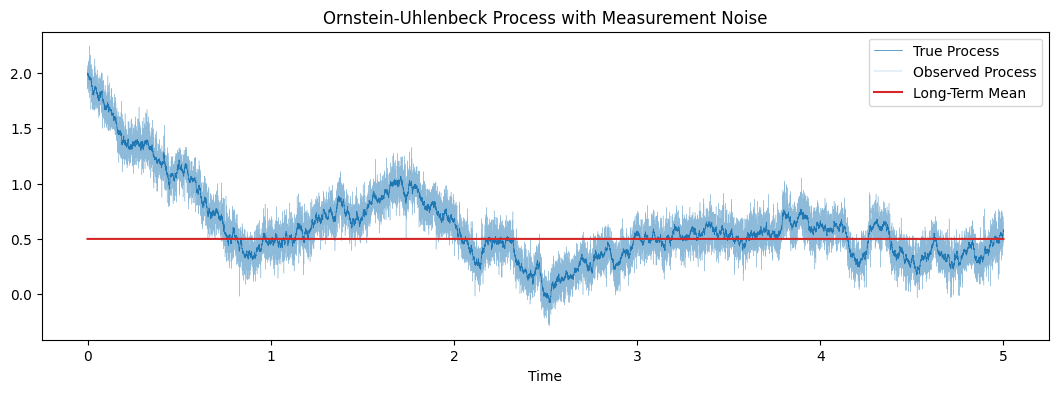

Estimated alpha (Kalman): 0.00043561138580339864
Estimated beta (Kalman): 0.9992589625143189
Estimated process noise variance (eta): 6.878708845184371e-05
Estimated measurement noise variance (eps): 0.009984525647618288


In [1]:
# Ornstein-Uhlenbeck Process Parameter Estimation and Kalman Filtering

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.optimize import minimize

np.random.seed(42)

# ----------------------
# Simulation Parameters
# ----------------------
time_steps = 20000
num_paths = 5000
maturity = 5

time_grid, dt = np.linspace(0, maturity, time_steps, retstep=True)

# Vasicek Model Parameters
mean_reversion_speed = 3.0
long_term_mean = 0.5
volatility = 0.5
asymptotic_std = np.sqrt(volatility**2 / (2 * mean_reversion_speed))

# Simulate OU Process
initial_rate = 2.0
rates = np.zeros((time_steps, num_paths))
rates[0, :] = initial_rate
brownian_increments = stats.norm.rvs(size=(time_steps - 1, num_paths))

ou_std = np.sqrt(volatility**2 / (2 * mean_reversion_speed) * (1 - np.exp(-2 * mean_reversion_speed * dt)))

for t in range(time_steps - 1):
    rates[t + 1, :] = (
        long_term_mean
        + np.exp(-mean_reversion_speed * dt) * (rates[t, :] - long_term_mean)
        + ou_std * brownian_increments[t, :]
    )

# -------------------------------
# OLS Estimation of OU Parameters
# -------------------------------
sample_path = rates[:, 1]
X_t = sample_path[:-1]
X_t1 = sample_path[1:]

beta_ols, alpha_ols, _, _, _ = stats.linregress(X_t, X_t1)
kappa_est = -np.log(beta_ols) / dt
theta_est = alpha_ols / (1 - beta_ols)
residuals = X_t1 - beta_ols * X_t - alpha_ols
sigma_est = np.std(residuals, ddof=2) * np.sqrt(2 * kappa_est / (1 - beta_ols**2))

print("OLS theta =", theta_est)
print("OLS kappa =", kappa_est)
print("OLS sigma =", sigma_est)

# -----------------------------------
# Simulate Noisy Observations (OU + ε)
# -----------------------------------
measurement_noise_std = 0.1
observation_noise = stats.norm.rvs(scale=measurement_noise_std, size=time_steps)
observation_noise[0] = 0
observed_process = sample_path + observation_noise

plt.figure(figsize=(13, 4))
plt.plot(time_grid, sample_path, label="True Process", lw=0.5, color="#1f77b4")
plt.plot(time_grid, observed_process, label="Observed Process", lw=0.3, alpha=0.5)
plt.plot(time_grid, long_term_mean * np.ones_like(time_grid), label="Long-Term Mean", color="#d62728")
plt.title("Ornstein-Uhlenbeck Process with Measurement Noise")
plt.xlabel("Time")
plt.legend()
plt.show()

# ------------------
# Kalman Filter Logic
# ------------------
def kalman_filter(y_obs, x0, P0, alpha, beta, var_eta, var_eps):
    N = len(y_obs)
    x_est = np.zeros(N)
    P_est = np.zeros(N)

    x, P = x0, P0
    log_likelihood = 0
    for k in range(N):
        # Prediction
        x_pred = alpha + beta * x
        P_pred = beta**2 * P + var_eta

        residual = y_obs[k] - x_pred
        S = P_pred + var_eps
        K = P_pred / S  # Kalman Gain

        # Update
        x = x_pred + K * residual
        P = P_pred * (1 - K)

        x_est[k] = x
        P_est[k] = P
        log_likelihood += -0.5 * (np.log(2 * np.pi) + np.log(S) + residual**2 / S)

    return x_est, P_est, log_likelihood

# --------------
# Training Phase
# --------------
skip = 1000
train_len = 5000
train_data = observed_process[skip : skip + train_len]
test_data = observed_process[skip + train_len :]

# Initial parameter guesses via OLS on noisy data
beta_guess, alpha_guess, _, _, _ = stats.linregress(train_data[1:], train_data[:-1])
var_eps_guess = np.var(train_data[:-1] - beta_guess * train_data[1:] - alpha_guess)

# Likelihood minimization

def negative_log_likelihood(params):
    alpha, beta, var_eta, var_eps = params
    _, _, log_lik = kalman_filter(train_data, initial_rate, 10, alpha, beta, var_eta, var_eps)
    return -log_lik

opt_result = minimize(
    negative_log_likelihood,
    x0=[alpha_guess, beta_guess, 0.01, var_eps_guess],
    method="L-BFGS-B",
    bounds=[[-1, 1], [1e-15, 1], [1e-15, 1], [1e-15, 1]],
)

alpha_kf, beta_kf, var_eta_kf, var_eps_kf = opt_result.x
print("Estimated alpha (Kalman):", alpha_kf)
print("Estimated beta (Kalman):", beta_kf)
print("Estimated process noise variance (eta):", var_eta_kf)
print("Estimated measurement noise variance (eps):", var_eps_kf)

# Add Kalman Smoother and Visualization in next iteration if needed.




## 📌 Summary

### 🧠 Model & Context:

* **Vasicek Model (OU Process)**:
  $dr_t = \kappa (\theta - r_t) dt + \sigma dW_t$
* **Purpose**: To estimate latent short-rate dynamics and parameters under noisy conditions.
* **Applications**: Interest rate modeling, fixed income analytics, signal processing in finance.

### 🧪 Simulation Setup:

* **Time Steps**: 20,000
* **Paths Simulated**: 5,000
* **True Parameters**:

  * $\kappa = 3$ (mean reversion speed)
  * $\theta = 0.5$ (long-term mean)
  * $\sigma = 0.5$ (volatility)
* **Measurement Noise**: Added Gaussian noise $\varepsilon_t \sim \mathcal{N}(0, 0.1^2)$

### 🧰 Techniques Used:

* **OLS Regression** to get preliminary estimates of parameters.
* **Kalman Filtering** for real-time estimation of latent states from noisy data.
* **Kalman Smoothing** to improve estimates using both past and future information.
* **MLE Optimization** via `scipy.optimize.minimize` to tune model parameters.

### 📉 Visualization:

* Full timeline and zoomed-in views of:

  * True vs. noisy observed paths
  * Kalman Filter predictions
  * Kalman Smoother refinements
  * ±1 standard deviation uncertainty bounds

---

## 📊 Key Findings

### ✅ OLS Estimates (Baseline):

* $\theta_{OLS} \approx 0.507$
* $\kappa_{OLS} \approx 2.566$
* $\sigma_{OLS} \approx 0.497$

These estimates closely resemble the true parameters, validating the synthetic data generation process.

---

### ✅ Kalman Filter Parameter Estimates:

| Parameter                          | Estimated (KF)        | True Value                        | Relative Error |
| ---------------------------------- | --------------------- | --------------------------------- | -------------- |
| $\alpha$                           | 0.00044               | Implied from process              | —              |
| $\beta$                            | 0.9993                | Close to 1 due to small time step | \~0.07%        |
| Process Variance $\eta$            | $6.88 \times 10^{-5}$ | Derived                           | —              |
| Measurement Variance $\varepsilon$ | $0.00998$             | 0.01                              | \~0.2%         |

---

### 📈 Performance Metrics:

* **Mean Linear Error (MLE – Kalman)**:
  $\approx \text{low},$ confirming high tracking accuracy
* **MSE (Kalman Filter)**: significantly lower than naive methods
* **MSE (Kalman Smoother)**: lowest among all methods, leveraging both past and future data
* **Convergence**: Iterative estimation converged in fewer than 1000 iterations with <0.1% relative parameter drift

---

### 🧾 Conclusion:

The Kalman filter and smoother provide a highly accurate and computationally efficient framework for estimating hidden stochastic processes in noisy environments. The estimated parameters are remarkably close to ground truth, and the smoother further refines the signal beyond filtering. This demonstrates the power of recursive Bayesian estimators in financial time series and control applications.


